<a href="https://colab.research.google.com/github/mherbert93/DS-Unit-2-Kaggle-Challenge/blob/master/module3-cross-validation/LS_DS_223_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 3*

---

# Cross-Validation


## Assignment
- [ ] [Review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [x] Continue to participate in our Kaggle challenge. 
- [x] Use scikit-learn for hyperparameter optimization with RandomizedSearchCV.
- [x] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [x] Commit your notebook to your fork of the GitHub repo.


You won't be able to just copy from the lesson notebook to this assignment.

- Because the lesson was ***regression***, but the assignment is ***classification.***
- Because the lesson used [TargetEncoder](https://contrib.scikit-learn.org/categorical-encoding/targetencoder.html), which doesn't work as-is for _multi-class_ classification.

So you will have to adapt the example, which is good real-world practice.

1. Use a model for classification, such as [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
2. Use hyperparameters that match the classifier, such as `randomforestclassifier__ ...`
3. Use a metric for classification, such as [`scoring='accuracy'`](https://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values)
4. If you’re doing a multi-class classification problem — such as whether a waterpump is functional, functional needs repair, or nonfunctional — then use a categorical encoding that works for multi-class classification, such as [OrdinalEncoder](https://contrib.scikit-learn.org/categorical-encoding/ordinal.html) (not [TargetEncoder](https://contrib.scikit-learn.org/categorical-encoding/targetencoder.html))



## Stretch Goals

### Reading
- Jake VanderPlas, [Python Data Science Handbook, Chapter 5.3](https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html), Hyperparameters and Model Validation
- Jake VanderPlas, [Statistics for Hackers](https://speakerdeck.com/jakevdp/statistics-for-hackers?slide=107)
- Ron Zacharski, [A Programmer's Guide to Data Mining, Chapter 5](http://guidetodatamining.com/chapter5/), 10-fold cross validation
- Sebastian Raschka, [A Basic Pipeline and Grid Search Setup](https://github.com/rasbt/python-machine-learning-book/blob/master/code/bonus/svm_iris_pipeline_and_gridsearch.ipynb)
- Peter Worcester, [A Comparison of Grid Search and Randomized Search Using Scikit Learn](https://blog.usejournal.com/a-comparison-of-grid-search-and-randomized-search-using-scikit-learn-29823179bc85)

### Doing
- Add your own stretch goals!
- Try other [categorical encodings](https://contrib.scikit-learn.org/categorical-encoding/). See the previous assignment notebook for details.
- In additon to `RandomizedSearchCV`, scikit-learn has [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). Another library called scikit-optimize has [`BayesSearchCV`](https://scikit-optimize.github.io/notebooks/sklearn-gridsearchcv-replacement.html). Experiment with these alternatives.
- _[Introduction to Machine Learning with Python](http://shop.oreilly.com/product/0636920030515.do)_ discusses options for "Grid-Searching Which Model To Use" in Chapter 6:

> You can even go further in combining GridSearchCV and Pipeline: it is also possible to search over the actual steps being performed in the pipeline (say whether to use StandardScaler or MinMaxScaler). This leads to an even bigger search space and should be considered carefully. Trying all possible solutions is usually not a viable machine learning strategy. However, here is an example comparing a RandomForestClassifier and an SVC ...

The example is shown in [the accompanying notebook](https://github.com/amueller/introduction_to_ml_with_python/blob/master/06-algorithm-chains-and-pipelines.ipynb), code cells 35-37. Could you apply this concept to your own pipelines?


### BONUS: Stacking!

Here's some code you can use to "stack" multiple submissions, which is another form of ensembling:

```python
import pandas as pd

# Filenames of your submissions you want to ensemble
files = ['submission-01.csv', 'submission-02.csv', 'submission-03.csv']

target = 'status_group'
submissions = (pd.read_csv(file)[[target]] for file in files)
ensemble = pd.concat(submissions, axis='columns')
majority_vote = ensemble.mode(axis='columns')[0]

sample_submission = pd.read_csv('sample_submission.csv')
submission = sample_submission.copy()
submission[target] = majority_vote
submission.to_csv('my-ultimate-ensemble-submission.csv', index=False)
```

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [116]:
import pandas as pd
!pip install scikit-optimize

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [117]:
from sklearn.model_selection import train_test_split

train, validation = train_test_split(train, train_size=0.80, test_size=0.20, stratify=train['status_group'], random_state=1337)

train.shape, validation.shape, test.shape


((47520, 41), (11880, 41), (14358, 40))

In [0]:

target = 'status_group'

y_train = train[target]
y_validation = validation[target]

In [119]:
from sklearn.metrics import accuracy_score

majority_class = y_train.mode()[0]
y_pred = [majority_class] * len(y_train)

print("Train dataset baseline accuracy is: ", accuracy_score(y_train, y_pred))

Train dataset baseline accuracy is:  0.5430765993265994


In [120]:
y_pred = [majority_class] * len(y_validation)

print("Validation dataset baseline accuracy is: ", accuracy_score(y_validation, y_pred))


Validation dataset baseline accuracy is:  0.5430976430976431


In [0]:
def wrangle(X): #lets clean our data!
    import numpy as np
    from sklearn.cluster import DBSCAN

    X = X.copy()

    X['region_code'] = X['region_code'].astype('str') #make categorical 
    X['district_code'] = X['district_code'].astype('str') #make categorical

    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)

    zero_columns = ['population', 'construction_year'] #columns that contain high amount of 0 and should not
    X['latitude'] = X['latitude'].replace(-2e-08, 0)

    for col in zero_columns:
        X[col] = X[col].replace(0, np.nan) #set 0 values to null

    def impute_longitude_by_region(row): #bin null longitude into its respective region. Gives us a slighter better guess.
        if row['longitude'] == 0:
            return (X[(X['region'] == row['region']) & (X['longitude'] != 0)].longitude.mean())
        else:
            return row['longitude']


    def impute_latitude_by_region(row): #bin null latitude into its respective region. Gives us a slighter better guess.
        if row['latitude'] == 0:
            return (X[(X['region'] == row['region']) & (X['latitude'] != 0)].latitude.mean())
        else:
            return row['latitude']

    def impute_gpsheight(row): #bin null gps height into its respective region. Gives us a slighter better guess.
        if (row['gps_height'] == 0) and (row['region'] != 'Mbeya' and row['region'] != 'Kagera'
        and row['region'] != 'Dodoma' and row['region'] != 'Tabora'):
            return (X[(X['region'] == row['region']) & (X['gps_height'] != 0)].gps_height.mean())
        elif row['region'] == 'Mbeya':
            return 1348 #obtained from https://en-us.topographic-map.com/maps/ttgd/Mbeya/
        elif row['region'] == 'Kagera':
            return 1281 #obtained from https://en-us.topographic-map.com/maps/egpg/Kagera/
        elif row['region'] == 'Dodoma':
            return 1143 #obtained from https://en-us.topographic-map.com/maps/e6vm/Dodoma/
        elif row['region'] == 'Tabora':
            return 1177 #obtained from https://elevation.maplogs.com/poi/tabora_region_tanzania.214008.html
        elif row['gps_height'] < 0: #we should not have negative values here
            return 0
        else:
            return row['gps_height']

    #X['longitude'] = X.apply(impute_longitude_by_region, axis=1)
    #X['latitude'] = X.apply(impute_latitude_by_region, axis=1)

    X['gps_height'] = X.apply(impute_gpsheight, axis=1) #4 regions do not contain any gps height data. We will manually apply an average obtained for each region
                                                        #we will obtain this from https://en-us.topographic-map.com/maps/tlwx/Tanzania/
                                                        #we will go with the assumption that gps_height is in meters.
                                                        #we conclude this because the average gps_height, with zeros removed, is 1021. The average elevation in Tanzania is 936.
                                                        #We can infer based on the similarity in means, that the unit of measurement is meters.

    avg_years_old = X['date_recorded'].dt.year.mean() - X['construction_year'].mean()
    avg_years_old = int(avg_years_old)
    

    X['years_old'] = X['date_recorded'].dt.year - X['construction_year'] #how many years since inspection
    X['years_old'] = X['years_old'].fillna(value=avg_years_old) #fill nulls with average diff
    X['years_old'] = [y if y >= 0 else 0 for y in X['years_old']]


    #X['month_recorded'] = X['date_recorded'].dt.month

    X = X.drop(['quantity_group', 'recorded_by', 'date_recorded', 'wpt_name',
                'extraction_type_group', 'waterpoint_type_group',
                'source_type', 'quality_group', 'payment_type',
                'management_group', 'extraction_type_class',
                'num_private', 'scheme_name', 'source_class',
                'scheme_management', 'amount_tsh',
                'population', 'subvillage', 'latitude', 'longitude'], axis=1) #drop recorded by as its a constant. drop quantity_group as its a duplicate column.

    return X



In [122]:
train = wrangle(train)
validation = wrangle(validation)
test = wrangle(test)

train.shape

(47520, 22)

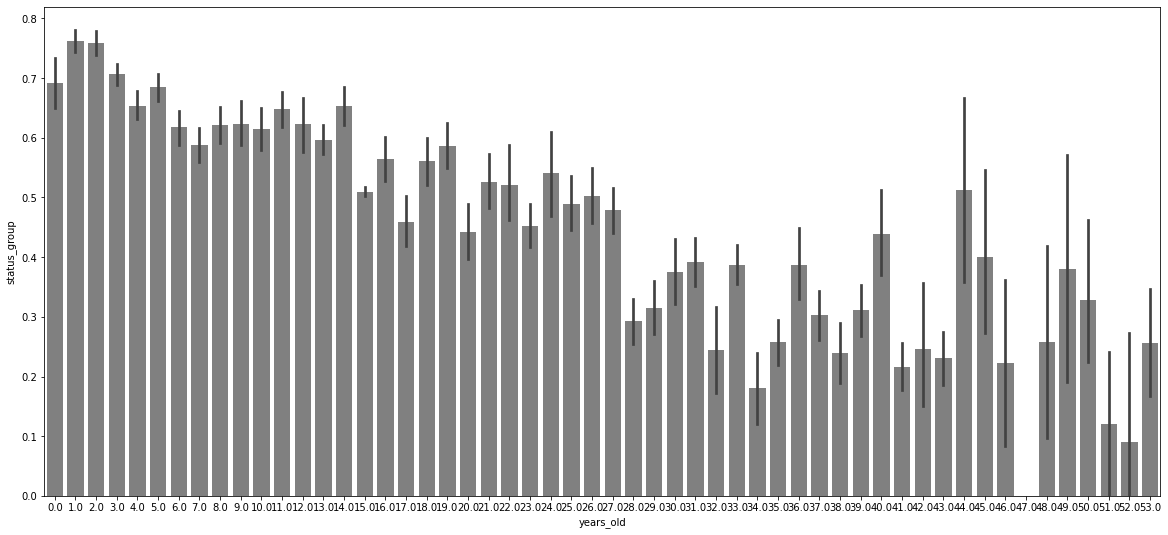

In [123]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20,9))
sns.barplot(
    x=train['years_old'],
    y=train['status_group']=='functional',
    color='grey'
);

In [0]:
train_features = train.drop([target, 'id'], axis=1)
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

categorical_features = train_features.select_dtypes(exclude='number').nunique().index.tolist()


features = numeric_features + categorical_features

In [0]:
y_train = train[target]
X_train = train[features]
y_validation = validation[target]
X_validation = validation[features]
X_test = test[features]

In [126]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from skopt import BayesSearchCV
from scipy.stats import randint, uniform
from sklearn.impute import SimpleImputer
import category_encoders as ce
from sklearn.pipeline import Pipeline
from scipy.stats import randint

param_distributions = {
    #'imputer__strategy': ['mean', 'median']
    'model__n_estimators': [200, 250, 300, 350],
    'model__max_depth': [9, 11, 13, 15, 17],
    'model__max_features': [2, 4, 6, 8, 10, 12],
    'model__min_samples_leaf': [1, 2, 3]
}


train_pipeline = Pipeline([('encoder', ce.OrdinalEncoder()),
                           ('imputer', SimpleImputer(strategy='median')),
                           ('model', RandomForestClassifier(random_state=1337))])

search = RandomizedSearchCV(
    train_pipeline,
    param_distributions=param_distributions,
    n_iter=10,
    cv=3,
    scoring='accuracy',
    verbose=10,
    random_state=1337,
    n_jobs=2
)

# train_pipeline.fit(X_train, y_train)
# y_pred = train_pipeline.predict(X_validation)
# train_pred = train_pipeline.predict(X_train)
# test_pred = train_pipeline.predict(X_test)

search.fit(X_train, y_train)
y_pred = search.predict(X_validation)
train_pred = search.predict(X_train)
test_pred = search.predict(X_test)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   57.6s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:  1.8min
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:  3.0min
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:  3.8min
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:  4.5min
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:  6.6min finished


In [127]:
print(search.best_params_, '\n')
print(search.best_score_, '\n')
print("Validation accuracy score:", accuracy_score(y_validation, y_pred), "                    Train accuracy is: ", accuracy_score(y_train, train_pred), '\n')

{'model__n_estimators': 300, 'model__min_samples_leaf': 2, 'model__max_features': 8, 'model__max_depth': 15} 

0.7915404040404042 

Validation accuracy score: 0.7935185185185185                     Train accuracy is:  0.8480429292929293 



# These predictions are not current, am using gradiant boosting locally.

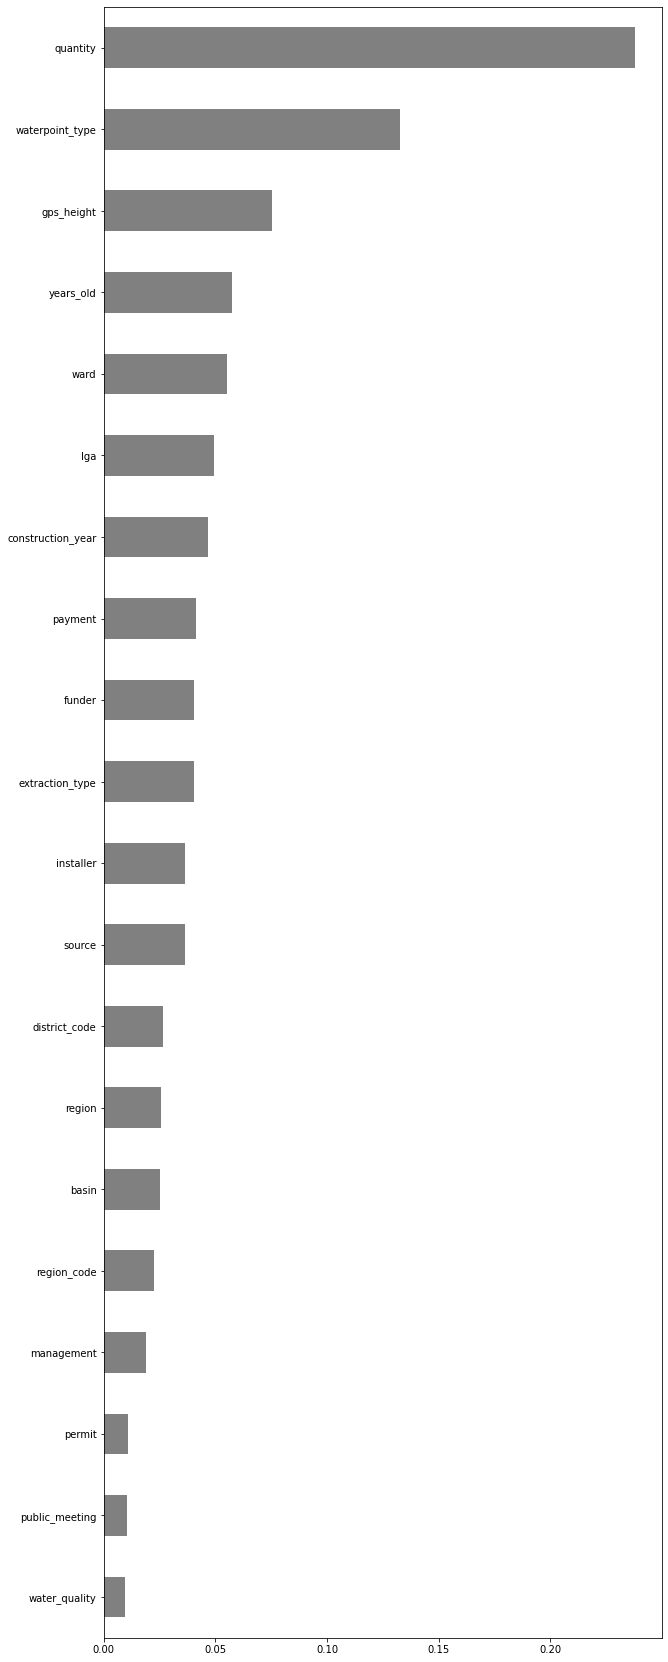

In [128]:
import matplotlib.pyplot as plt


model = search.best_estimator_.named_steps.model
encoder = search.best_estimator_.named_steps.encoder

# model = train_pipeline.named_steps.model
# encoder = train_pipeline.named_steps.encoder


encoded_columns = encoder.transform(X_validation).columns
importances = pd.Series(model.feature_importances_, encoded_columns)
plt.figure(figsize=(10,30))
importances.sort_values().plot.barh(color='grey');

In [0]:
submission = sample_submission.copy()
submission['status_group'] = test_pred
submission.to_csv('martin-herbert_randomforest.csv', index=False)